<a href="https://www.kaggle.com/code/yaaangzhou/commonlit-easy-for-beginner-roberta-baseline?scriptVersionId=142316330" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**[CommonLit]Easy for Beginner:Roberta Baseline**

**7 Sep 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">[CommonLit]Easy for Beginner:Roberta Baseline</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Automatically assess summaries written by students in grades 3-12</center></p>

***

**The goal of this competition is to generate a model to automatically score student summaries.The goal of the competition is to help teachers and learning platforms provide better feedback to students on their writing.**

**I used ML modeles in another [notebook](https://www.kaggle.com/code/yaaangzhou/commonlit-machine-learning-baseline-model), but it was obvious that it did not work well as a baseline model, so I considered further using LLM to complete the task.**

# 0. Imports

In [1]:
import numpy as np
import pandas as pd

import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from datasets import Dataset as Dataset_HF
from torch.utils.data import Dataset

import torch
import gc
import re

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Load Datas

In [2]:
data_dir = "/kaggle/input/commonlit-evaluate-student-summaries/"
train_pro = pd.read_csv(data_dir + 'prompts_train.csv')
train_sum = pd.read_csv(data_dir + 'summaries_train.csv')

test_pro = pd.read_csv(data_dir + 'prompts_test.csv')
test_sum = pd.read_csv(data_dir + 'summaries_test.csv')

submission = pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
train = train_sum.merge(train_pro, how="left", on="prompt_id")
test = test_sum.merge(test_pro, how="left", on="prompt_id")

print("Full train dataset shape is {}".format(train.shape))

Full train dataset shape is (7165, 8)


In [4]:
train.head(3)

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...


# 2. Data Prepocessing

First, we need to remove some special symbols in the text because it has no semantic meaning.

In [5]:
train['text'] = train["text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
test['text'] = test["text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

# 3. Set Configuration

In [6]:
class CFG:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    max_length=512
    hidden_dropout_prob=0.005
    attention_probs_dropout_prob=0.005
    model_name = "distilroberta-base"
    tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/distilroberta-base')
    model = AutoModelForSequenceClassification.from_pretrained('/kaggle/input/distilroberta-base',num_labels=2,problem_type="regression").to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model_config = AutoConfig.from_pretrained('/kaggle/input/distilroberta-base')
model_config.update({
        "hidden_dropout_prob": CFG.hidden_dropout_prob,
        "attention_probs_dropout_prob": CFG.attention_probs_dropout_prob,
        "num_labels": 2,
        "problem_type": "regression",
    })

## Data Collector

In [8]:
data_collator = DataCollatorWithPadding(tokenizer=CFG.tokenizer)

## Evaluation Function

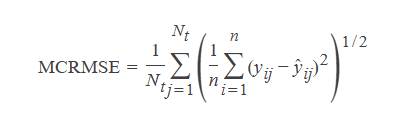

In [9]:
def caculate_mcrmse(eval_pred):
    predictions, labels = eval_pred
    squared_errors = np.square(predictions - labels)
    mean_squared_errors = np.mean(squared_errors, axis=0)
    rmse = np.sqrt(mean_squared_errors)

    mcrmse_value = np.mean(rmse)
    content_rmse = rmse[0]
    wording_rmse = rmse[1]
    
    return {
        "mcrmse": mcrmse_value,
        "content_rmse": content_rmse,
        "wording_rmse": wording_rmse
    }

In [10]:
df_train, df_valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train['prompt_id'])

# 4. Dataset for different targets

In [11]:
df_train.head(3)

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
3916,8a31b8cc1996,3b9047,In the social pyramid of ancient Egypt the pha...,-0.077267,0.424365,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3985,8c9411cfc953,39c16e,Aristotle claims that an ideal tragedy should ...,0.559070,-0.634924,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1888,4387107feb4d,3b9047,The ancient Egyptian system of government was ...,1.376083,2.389443,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...


In [12]:
train_content = df_train[["prompt_question", "text", "content", "wording"]]
valid_content = df_valid[["prompt_question", "text", "content", "wording"]]

df_test = test[["prompt_question","text"]]

**Now we need to transform the dataframe to dataset.**

In [13]:
train_dataset_content = Dataset_HF.from_pandas(train_content, preserve_index=False) 
valid_dataset_content = Dataset_HF.from_pandas(valid_content, preserve_index=False) 
test_dataset = Dataset_HF.from_pandas(df_test, preserve_index=False) 

# 5. Tokenizer

**We need to tokenize the text before put it into a model. We are gonna distinguish between training set and test set. If it is a training set, the tokenizer will return a dictionary including input id, attention mask, and labels.**

**If it is a training set, only the input id and attention mask will be returned.**

In [14]:
def tokenize_function(examples,dataset='train'):
    if dataset == 'train':
        labels = [examples["content"], examples["wording"]]
        tokenized = CFG.tokenizer(examples["text"],
                                  examples["prompt_question"],
                                  padding=False,
                                  truncation=True,
                                  max_length=CFG.max_length)
        return {**tokenized,"labels": labels}
        
    elif dataset == 'test':
        tokenized = CFG.tokenizer(examples["text"],
                                  examples["prompt_question"],
                                  padding=False,
                                  truncation=True,
                                  max_length=CFG.max_length)
        
        return tokenized

In [15]:
train_tokenized_datasets_content = train_dataset_content.map(lambda example: tokenize_function(example, dataset='train'), batched=False)
valid_tokenized_datasets_content = valid_dataset_content.map(lambda example: tokenize_function(example, dataset='train'), batched=False)
test_tokenized_datasets_content = test_dataset.map(lambda example: tokenize_function(example,dataset='test'),batched=False)

  0%|          | 0/5732 [00:00<?, ?ex/s]

  0%|          | 0/1433 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ex/s]

In [16]:
gc.collect()

174

# 6. Training a model

In [17]:
training_args = TrainingArguments(
    output_dir="output",             
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=4,    
    learning_rate=1.5e-5,            
    lr_scheduler_type="linear",      
    warmup_ratio=0.01,               
    num_train_epochs=15,              
    save_strategy="epoch",           
    logging_strategy="epoch",        
    evaluation_strategy="epoch",    
    load_best_model_at_end=True,     
    metric_for_best_model="mcrmse",  
    greater_is_better=False,         
    fp16=False,                      
    report_to='none',                
    save_total_limit=1               
)

trainer = Trainer(
    model=CFG.model,
    train_dataset=train_tokenized_datasets_content,
    eval_dataset=valid_tokenized_datasets_content,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=caculate_mcrmse,
    tokenizer=CFG.tokenizer
)
trainer.train()

trainer.save_model("best_model")

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Mcrmse,Content Rmse,Wording Rmse
1,0.442800,0.287768,0.530185,0.448504,0.611866
2,0.277700,0.298986,0.541776,0.467848,0.615703
3,0.228000,0.348440,0.586228,0.517118,0.655338
4,0.189800,0.268272,0.515009,0.459896,0.570122
5,0.162200,0.251474,0.497914,0.438284,0.557544
6,0.136100,0.262401,0.509353,0.454938,0.563768
7,0.120100,0.269065,0.516094,0.464021,0.568167
8,0.102700,0.269348,0.516989,0.471483,0.562494
9,0.089500,0.285207,0.530260,0.466768,0.593753
10,0.079900,0.279349,0.525849,0.472630,0.579067


# 7. Prediction

In [18]:
predictions = trainer.predict(test_tokenized_datasets_content)
predictions

PredictionOutput(predictions=array([[-1.3094829, -1.1639411],
       [-1.3149625, -1.1748605],
       [-1.322452 , -1.1852924],
       [-1.3239895, -1.1803738]], dtype=float32), label_ids=None, metrics={'test_runtime': 0.011, 'test_samples_per_second': 362.758, 'test_steps_per_second': 90.69})

In [19]:
content_list = predictions.predictions[:, 0].tolist()
wording_list = predictions.predictions[:, 1].tolist()

In [20]:
submission["content"] = content_list
submission["wording"] = wording_list

submission.to_csv("submission.csv", index=False)
submission.head()

,student_id,content,wording
0,000000ffffff,-1.309483,-1.163941
1,111111eeeeee,-1.314963,-1.174860
2,222222cccccc,-1.322452,-1.185292
3,333333dddddd,-1.323990,-1.180374
